In [1]:
# Import the library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Explore_data import *

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from time import time

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [3]:
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split

In [4]:
day_dataset = pd.read_csv("Final_daily_data.csv")
month_dataset = pd.read_csv("Final_monthly_data.csv")
dataset = pd.read_csv("Final_dataset18.csv")

<Axes: >

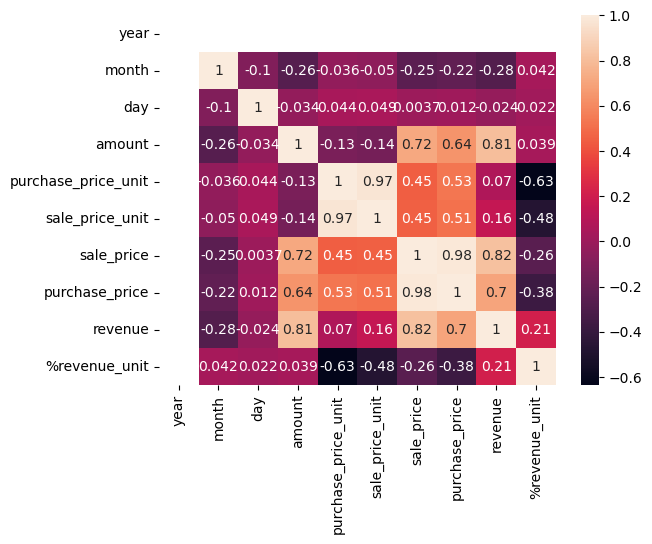

In [39]:
# Viewing the heatmap
sns.heatmap(get_num_columns(dataset).corr(), annot=True)

In [5]:
X, y = day_dataset.drop(["revenue", "sale_price"], axis= 1), day_dataset['revenue']

In [41]:
def preprocesing_dataX(num_df: pd.Series, obj_df:pd.Series, model = None):
    
    X = pd.DataFrame()
    ## obj_df
    for i, obj in enumerate(obj_df.columns):
        label = LabelEncoder()
        encode = label.fit_transform(obj_df[obj])
        X[obj] = encode
        
    ## num_df
    scale = StandardScaler()
    X[num_df.columns] = scale.fit_transform(num_df)
    
    ## column transformer
    ct = ColumnTransformer([('town', OneHotEncoder(), [0, 1, 2])], remainder = 'passthrough')
    X = ct.fit_transform(X)
    return X

In [42]:
_X = preprocesing_dataX(X, pd.DataFrame())

In [12]:
regressors = {
    "KNeighborsRegressor": KNeighborsRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge()
}

In [6]:
parameters = {
    "KNeighborsRegressor": {
        'n_neighbors': range(2, 10),
    },
    "GradientBoostingRegressor": { 
        'learning_rate' : (0.05,0.25,0.50,1)
    },
    "RandomForestRegressor": {
        'max_depth': [None, 1, 2, 3, 4, 5], 
        'min_samples_split': range(2, 10)
    },
    "DecisionTreeRegressor":{
        'max_depth' : [None, 5, 10],
        'min_samples_split': range(2, 10)
    },
    "LinearRegression": {
        "fit_intercept": [True, False],
    },
    "Lasso": {
        'alpha':[0.02, 0.024, 0.025, 0.026, 0.03],
        'fit_intercept':[True, False]
    },
    "Ridge": {
        'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'fit_intercept':[True, False]
    }

}

In [7]:
#Splitting the data into train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
def evaluate(model, name_model, X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start 
    error = abs(y_pred - y_test)
    mape = 100 * np.mean(error/y_test)
    accuracy = 100 - mape   

    result ={
            'model': {
                'name': name_model,
                'model': model,
                'y_test': y_test,
                'y_pred': y_pred

            },
            'evaluate': {
                'name': name_model,
                'Training_time': train_time,
                "Predict_time": predict_time,
                "Explained_variance": explained_variance_score(y_test, y_pred),
                "Average_Error": np.mean(error),
                "Accuracy": accuracy,
                "MSE": mean_absolute_error(y_test, y_pred),
                "R^2": r2_score(y_test, y_pred)
            }
        }
    
    return result

In [10]:
from sklearn.model_selection import GridSearchCV
def model_best(model, parameters, X, y, cv = None):
    grid = GridSearchCV(model,parameters, cv = cv)
    _model = grid.fit(X,y)
    print(_model.best_estimator_,'\n')

    return _model, _model.best_estimator_


In [ ]:
models = []
evaluates = []

## Dataset18 + GridSearchCV

In [ ]:
for name_model, model in regressors.items():

    _model, _model_best_estimator_ = model_best(model, parameters[name_model], X, y)
    _result = evaluate(_model,name_model, X, y)

    _result['model']['parameter'] = _model_best_estimator_
    _result['evaluate']['validate'] = "False"

    models.append(_result['model'])
    evaluates.append(_result['evaluate'])
    

In [19]:
df = pd.DataFrame(evaluates)
df[df['validate'] == "False"]

,name,Training_time,Predict_time,Explained_variance,Average_Error,Accuracy,MSE,R^2,validate
7,KNeighborsRegressor,0.374329,0.006976,0.802135,1.348089e+06,57.476454,1.348089e+06,0.792980,False
8,GradientBoostingRegressor,1.748184,0.001997,0.891036,1.023616e+06,73.704416,1.023616e+06,0.869503,False
9,RandomForestRegressor,33.763087,0.003990,0.910008,1.014541e+06,74.972185,1.014541e+06,0.900774,False
10,DecisionTreeRegressor,0.496491,0.001000,0.744026,1.558230e+06,72.348859,1.558230e+06,0.682313,False
11,LinearRegression,0.041405,0.001994,0.878541,1.086881e+06,76.557715,1.086881e+06,0.876997,False
12,Lasso,0.525320,0.000998,0.878701,1.086116e+06,76.567065,1.086116e+06,0.877144,False
13,Ridge,0.324735,0.000963,0.912601,9.647585e+05,68.208733,9.647585e+05,0.909271,False


## Dataset18 + GridSearchCV + RepeatedKFold

In [ ]:
# define evaluation
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:

for name_model, model in regressors.items():

    _model, _model_best_estimator_ = model_best(model, parameters[name_model], X, y, cv = cv)
    _result = evaluate(_model,name_model, X, y)

    _result['model']['parameter'] = _model_best_estimator_
    _result['evaluate']['validate'] = "True"

    models.append(_result['model'])
    evaluates.append(_result['evaluate'])

In [16]:
pd.DataFrame(evaluates)

,name,Training_time,Predict_time,Explained_variance,Average_Error,Accuracy,MSE,R^2,validate
0,KNeighborsRegressor,2.535803,0.004987,0.824256,1.252733e+06,57.828634,1.252733e+06,0.821681,True
1,GradientBoostingRegressor,11.359505,0.001995,0.856943,1.179738e+06,78.423531,1.179738e+06,0.824314,True
2,RandomForestRegressor,228.782266,0.003989,0.917780,1.009633e+06,72.855380,1.009633e+06,0.907625,True
3,DecisionTreeRegressor,3.209620,0.000997,0.837751,1.224113e+06,76.221010,1.224113e+06,0.807186,True
4,LinearRegression,0.273427,0.002027,0.878541,1.086881e+06,76.557715,1.086881e+06,0.876997,True
5,Lasso,3.105439,0.001994,0.878701,1.086116e+06,76.567065,1.086116e+06,0.877144,True
6,Ridge,1.762312,0.000997,0.912601,9.647585e+05,68.208733,9.647585e+05,0.909271,True


In [20]:
evaluate_df = pd.DataFrame(evaluates)
evaluate_df.sort_values(['R^2'], ascending= False).head(10)

,name,Training_time,Predict_time,Explained_variance,Average_Error,Accuracy,MSE,R^2,validate
6,Ridge,1.762312,0.000997,0.912601,9.647585e+05,68.208733,9.647585e+05,0.909271,True
13,Ridge,0.324735,0.000963,0.912601,9.647585e+05,68.208733,9.647585e+05,0.909271,False
2,RandomForestRegressor,228.782266,0.003989,0.917780,1.009633e+06,72.855380,1.009633e+06,0.907625,True
9,RandomForestRegressor,33.763087,0.003990,0.910008,1.014541e+06,74.972185,1.014541e+06,0.900774,False
5,Lasso,3.105439,0.001994,0.878701,1.086116e+06,76.567065,1.086116e+06,0.877144,True
12,Lasso,0.525320,0.000998,0.878701,1.086116e+06,76.567065,1.086116e+06,0.877144,False
4,LinearRegression,0.273427,0.002027,0.878541,1.086881e+06,76.557715,1.086881e+06,0.876997,True
11,LinearRegression,0.041405,0.001994,0.878541,1.086881e+06,76.557715,1.086881e+06,0.876997,False
8,GradientBoostingRegressor,1.748184,0.001997,0.891036,1.023616e+06,73.704416,1.023616e+06,0.869503,False
1,GradientBoostingRegressor,11.359505,0.001995,0.856943,1.179738e+06,78.423531,1.179738e+06,0.824314,True


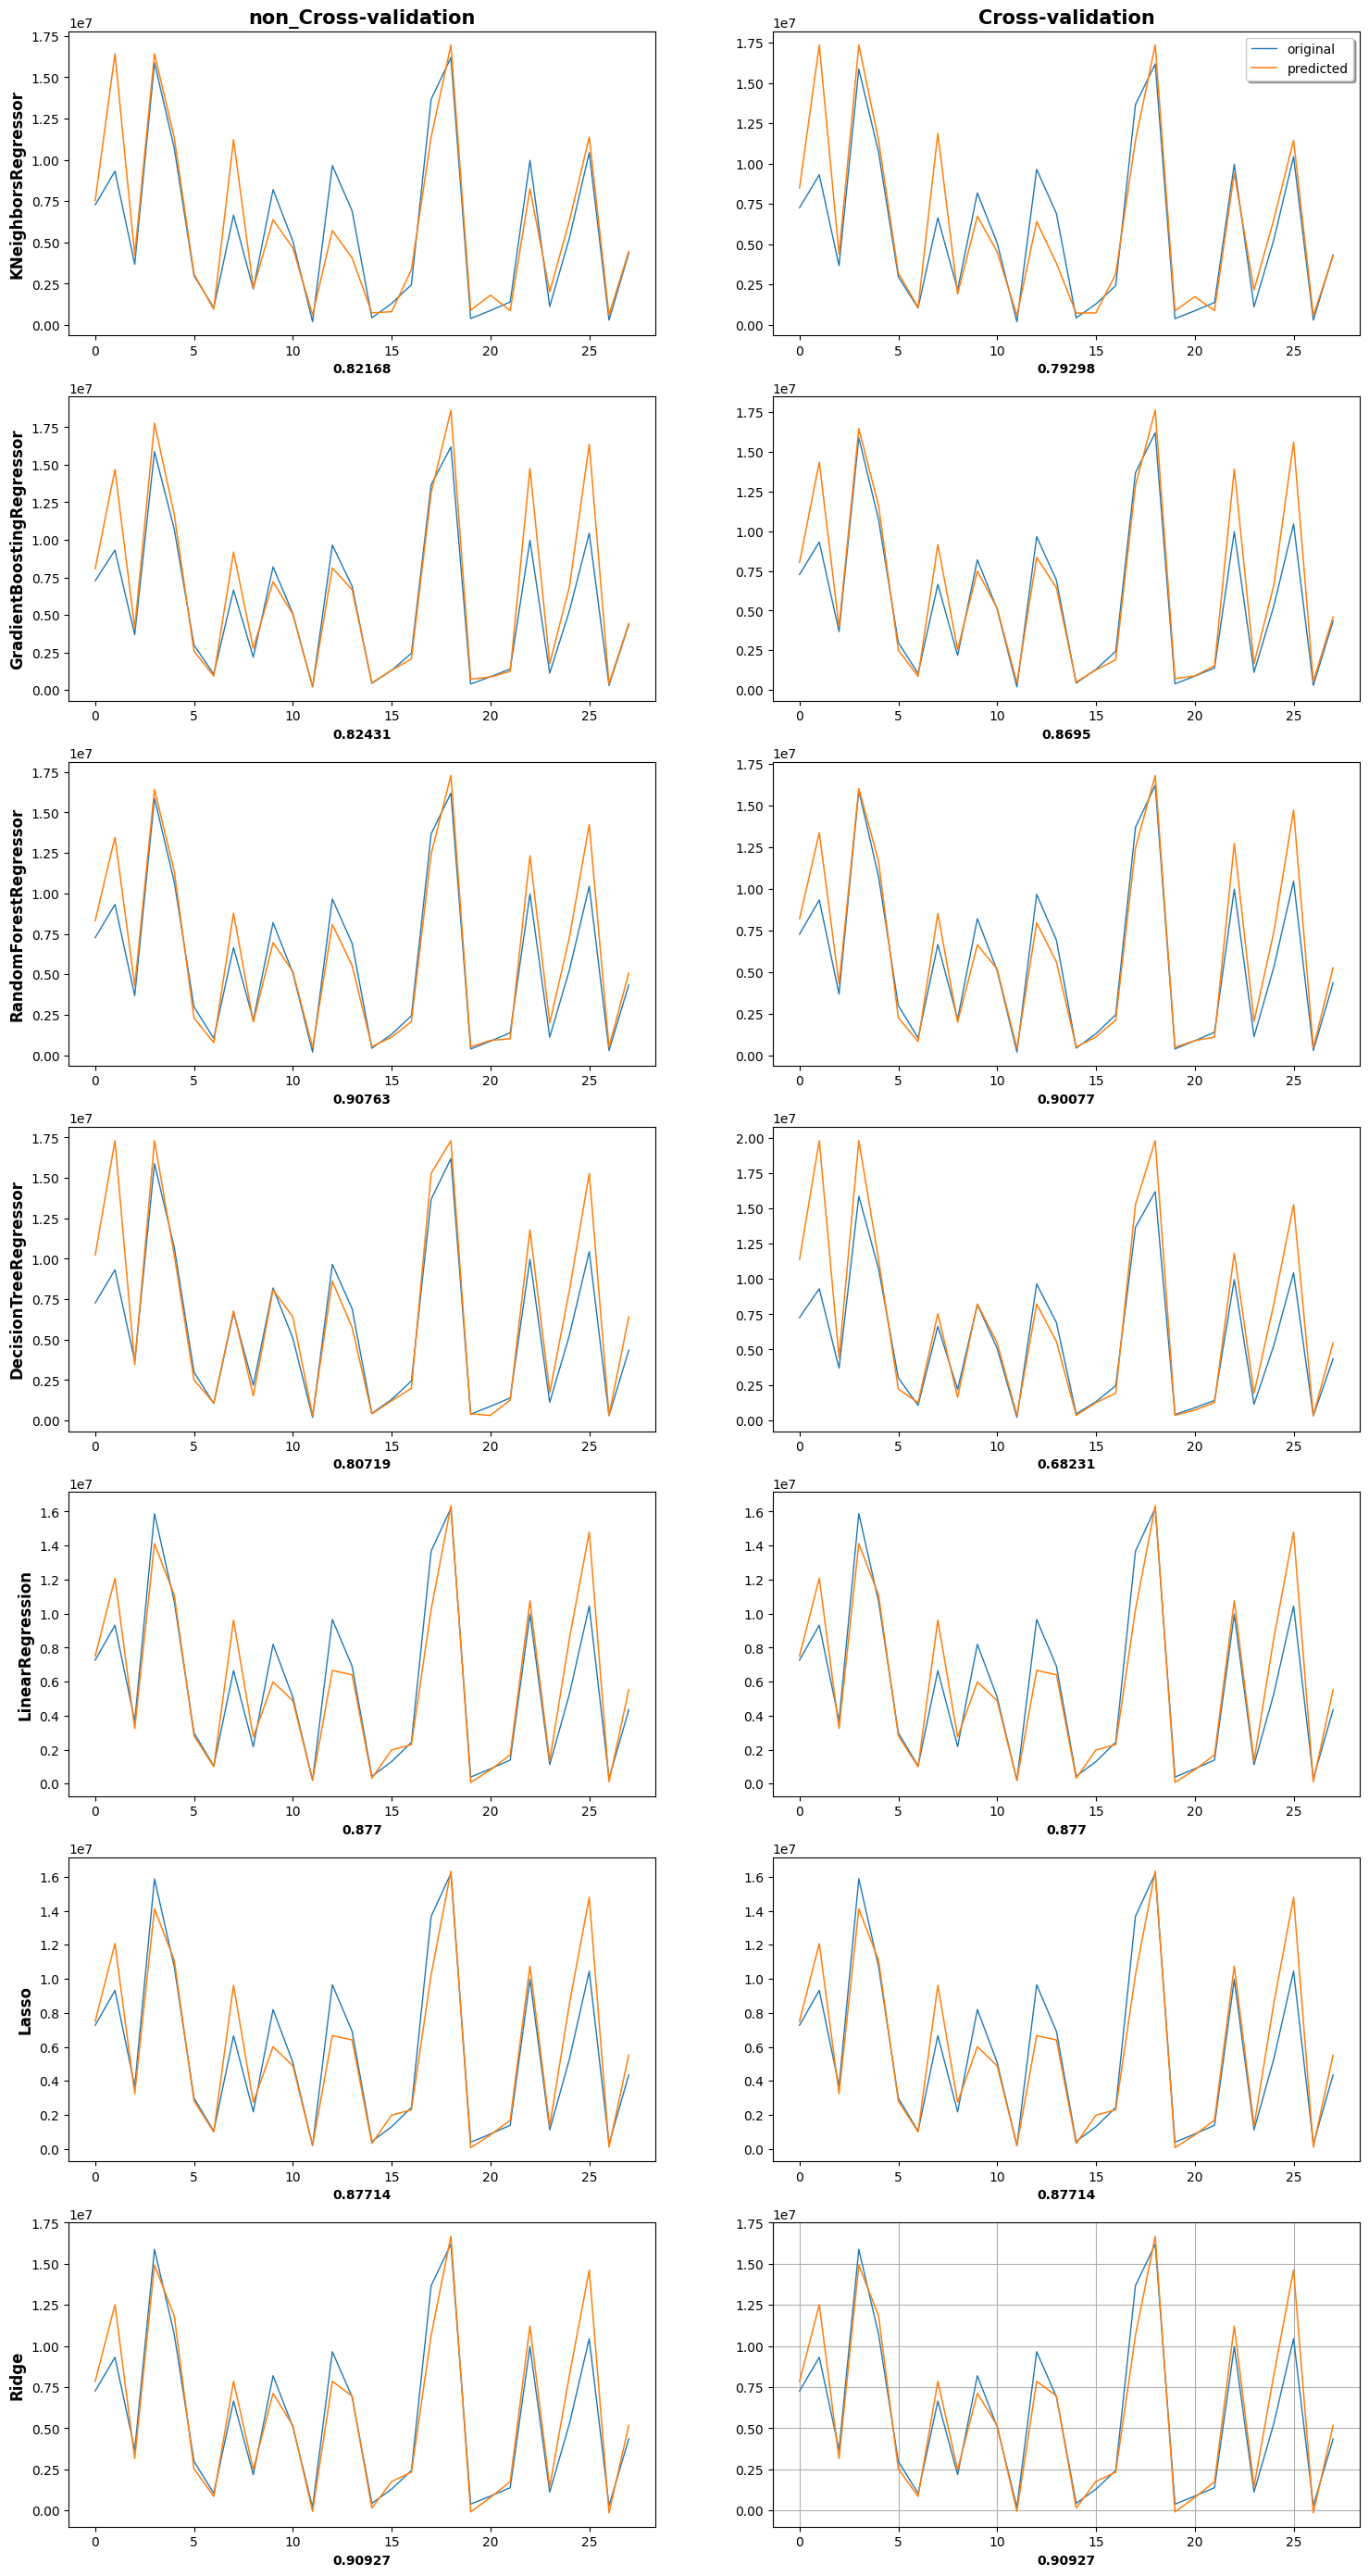

In [21]:
column, row = 2, len(regressors)
index = 0
fig, ax = plt.subplots(row, column, figsize = (9*column,5*row))
for j in range(column):
    for i in range(row):
        y_test = models[i + j*7]['y_test']
        y_pred = models[i + j*7]['y_pred']
        name = models[i + j*7]['name']
        r2 = round(evaluates[i + j*7]['R^2'], 5)
        x_ax = range(len(y_pred))
        ax[i][j].plot(x_ax, y_test, linewidth=1, label="original")
        ax[i][j].plot(x_ax, y_pred, linewidth=1.1, label="predicted")
        ax[i][0].set_ylabel(name, fontsize = 12, fontweight = 'bold')
        ax[i][j].set_xlabel(r2, fontweight = 'bold')

ax[0][0].set_title("non_Cross-validation", fontsize = 15, fontweight = 'bold')
ax[0][1].set_title("Cross-validation", fontsize = 15, fontweight = 'bold')
ax[0][1].legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [121]:
pd.DataFrame(evaluates)

,name,Training_time,Predict_time,Explained_variance,Average_Error,Accuracy,MSE,R^2,validate
0,KNeighborsRegressor,4.978580,0.125182,0.684616,2.231712e+06,57.171855,2.231712e+06,0.573631,False
1,GradientBoostingRegressor,2.879465,0.000000,0.891068,1.009290e+06,75.372894,1.009290e+06,0.872477,False
2,RandomForestRegressor,45.012088,0.007985,0.926568,9.997821e+05,66.596188,9.997821e+05,0.917387,False
3,DecisionTreeRegressor,0.433504,0.000000,0.772986,1.482794e+06,72.045063,1.482794e+06,0.722600,False
4,LinearRegression,0.029438,0.000000,0.841142,1.401831e+06,48.361844,1.401831e+06,0.837038,False
5,Lasso,0.803342,0.000000,0.854341,1.358422e+06,48.891754,1.358422e+06,0.848991,False
6,Ridge,0.204555,0.000000,0.902907,1.032199e+06,80.646747,1.032199e+06,0.900398,False


## Dataset + GridSearchCV

In [118]:
data_path = "Final_SALESDATA1.csv"
dataset = pd.read_csv(data_path)

In [119]:
num_df = dataset[['date', 'year', 'month', 'day']].groupby('date').agg(pd.Series.mode)
num_df = pd.concat([num_df,
                    dataset[['date', 'amount', 'purchase_price', 'sale_price', 'revenue']].groupby('date').sum()
                    ],
                    axis = 1)
num_df['%revenue'] = num_df['revenue']/num_df['purchase_price']*100
obj_df = dataset['date']
obj = get_obj_columns(dataset).columns[1:]
for column in obj:
    dummies = pd.get_dummies(dataset[column], dtype = float, prefix= 'amount')
    dummies.values[dummies != 0] = dataset.amount.values
    obj_df = pd.concat([obj_df, dummies], axis = 1)

obj_df = obj_df.groupby('date').sum()

day_dataset1 = pd.concat([num_df, obj_df],
                        axis = 1)

In [122]:
_X, _y = day_dataset1.drop(["revenue", "sale_price"], axis= 1), day_dataset1['revenue']

In [ ]:
models = []
evaluates = []
for name_model, model in regressors.items():

    _model, _model_best_estimator_ = model_best(model, parameters[name_model], _X, _y)
    _result = evaluate(_model,name_model, _X, _y)

    _result['model']['parameter'] = _model_best_estimator_
    _result['evaluate']['validate'] = "False"

    models.append(_result['model'])
    evaluates.append(_result['evaluate'])
    

In [124]:
pd.DataFrame(evaluates)

,name,Training_time,Predict_time,Explained_variance,Average_Error,Accuracy,MSE,R^2,validate
0,KNeighborsRegressor,5.910266,0.163579,0.483954,3.312419e+06,52.965911,3.312419e+06,0.483013,False
1,GradientBoostingRegressor,10.895401,0.008977,0.578334,2.665799e+06,57.885269,2.665799e+06,0.578333,False
2,RandomForestRegressor,115.030226,0.014943,0.443287,3.129828e+06,55.082088,3.129828e+06,0.441709,False
3,DecisionTreeRegressor,3.230779,0.007984,0.428486,3.728545e+06,41.596958,3.728545e+06,0.427124,False
4,LinearRegression,0.388085,0.022938,0.514006,3.319772e+06,57.067062,3.319772e+06,0.495787,False
5,Lasso,2.025102,0.023936,0.629822,3.123372e+06,39.788497,3.123372e+06,0.612639,False
6,Ridge,2.789961,0.011489,0.537381,3.228267e+06,57.411631,3.228267e+06,0.523907,False


## Dataset11 + GridSearchCV

In [22]:
data_path = "Final_Category11.csv"
dataset = pd.read_csv(data_path)

In [23]:
num_df = dataset[['date', 'year', 'month', 'day']].groupby('date').agg(pd.Series.mode)
num_df = pd.concat([num_df,
                    dataset[['date', 'amount', 'purchase_price', 'sale_price', 'revenue']].groupby('date').sum()
                    ],
                    axis = 1)
num_df['%revenue'] = num_df['revenue']/num_df['purchase_price']*100
obj_df = dataset['date']
obj = get_obj_columns(dataset).columns[1:]
for column in obj:
    dummies = pd.get_dummies(dataset[column], dtype = float, prefix= 'amount')
    dummies.values[dummies != 0] = dataset.amount.values
    obj_df = pd.concat([obj_df, dummies], axis = 1)

obj_df = obj_df.groupby('date').sum()

day_dataset1 = pd.concat([num_df, obj_df],
                        axis = 1)

In [24]:
_X, _y = day_dataset1.drop(["revenue", "sale_price"], axis= 1), day_dataset1['revenue']

In [ ]:
models = []
evaluates = []
for name_model, model in regressors.items():

    _model, _model_best_estimator_ = model_best(model, parameters[name_model], _X, _y)
    _result = evaluate(_model,name_model, _X, _y)

    _result['model']['parameter'] = _model_best_estimator_
    _result['evaluate']['validate'] = "False"

    models.append(_result['model'])
    evaluates.append(_result['evaluate'])
    

In [32]:
pd.DataFrame(evaluates)

,name,Training_time,Predict_time,Explained_variance,Average_Error,Accuracy,MSE,R^2,validate
0,KNeighborsRegressor,0.544423,0.006981,0.806287,1.386823e+06,123.511234,1.386823e+06,0.786370,False
1,GradientBoostingRegressor,1.761287,0.000998,0.875754,1.099578e+06,105.161200,1.099578e+06,0.869207,False
2,RandomForestRegressor,36.125762,0.006947,0.805216,1.371854e+06,111.402330,1.371854e+06,0.794677,False
3,DecisionTreeRegressor,0.696859,0.002003,0.125487,2.161766e+06,114.247123,2.161766e+06,0.107848,False
4,LinearRegression,0.065822,0.002061,0.346680,2.025682e+06,160.418776,2.025682e+06,0.337822,False
5,Lasso,0.532964,0.001023,-0.048930,2.293546e+06,267.470168,2.293546e+06,0.054702,False
6,Ridge,0.355741,0.001971,0.572690,1.593524e+06,70.908694,1.593524e+06,0.549009,False
